## DQN 특징

1. 더 깊은 네트워크 사용
2. experience replay 사용
3. separate network 사용

In [48]:
import gymnasium
import numpy as np
import random
import torch
import copy
import collections
import math
import itertools
from tqdm import tqdm

In [49]:
class ReplayBuffer:
    Transition = collections.namedtuple('Transition', 'state action reward next_state terminated')

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)
    
    def sample(self, batch_size):
        a = random.sample(self.memory, batch_size)
        d = zip(*a)
        b = [torch.tensor(i) for i in d]
        c = self.Transition(*b)
        return c
        # return self.Transition(*(torch.tensor(i) for i in zip(*random.sample(self.memory, batch_size))))
    
    def append(self, state, action, reward, next_state, terminated):
        self.memory.append(self.Transition(state, action, reward, next_state, terminated))

    def __len__(self):
        return len(self.memory)

In [50]:
env = gymnasium.make('CartPole-v1')
env._max_episode_steps = 10000
hidden_size = 128
q = torch.nn.Sequential(
    torch.nn.Linear(*env.observation_space.shape, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, env.action_space.n)
)
target_q = copy.deepcopy(q).requires_grad_(False)

In [51]:
lr = 0.00001
discount = 0.99
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(q.parameters(), lr=lr, amsgrad=True)
replay_buffer = ReplayBuffer(10000)
num_episodes = 1000  
batch_size = 2
sync_interval = 10
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005

In [52]:
# state, info = env.reset()
# for _ in range(300):
#     action = env.action_space.sample()
#     next_state, reward, terminated, truncated, info = env.step(action)
#     replay_buffer.append(state, action, reward, next_state, terminated)
#     state = next_state

# batch = replay_buffer.sample(2)
# state_action_values = q(batch.state).gather(1, batch.action.unsqueeze(0)).squeeze()
# next_state_values = torch.zeros_like(state_action_values)
# next_state_values[batch.terminated] = target_q(batch.next_state[batch.terminated]).max(1).values
# expected_state_action_values = next_state_values * discount + batch.reward
# loss = criterion(state_action_values, expected_state_action_values)
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

In [53]:
def optimize():
    if len(replay_buffer) < batch_size:
        return
    # batch = replay_buffer.sample(batch_size)
    # optimizer.zero_grad()
    # losses = []
    # for u, action, r, v, terminated in batch:
    #     uq = q(u) 
    #     if terminated:
    #         uq[action] = r
    #     else:
    #         uq[action] = r + discount * torch.max(target_q(v))
    #         # uq[action] = r + discount * target_q(v)[torch.argmax(q(v))]
    #     loss = criterion(uq, q(u))
    #     losses.append(loss)
    # sum(losses).backward()
    # torch.nn.utils.clip_grad_value_(optimizer.param_groups[0]['params'], 100)
    # optimizer.step()
    batch = replay_buffer.sample(batch_size)
    state_action_values = q(batch.state).gather(1, batch.action.unsqueeze(0)).squeeze()
    next_state_values = torch.zeros_like(state_action_values)
    next_state_values[batch.terminated] = target_q(batch.next_state[batch.terminated]).max(1).values
    expected_state_action_values = next_state_values * discount + batch.reward
    loss = criterion(state_action_values, expected_state_action_values)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(optimizer.param_groups[0]['params'], 100)
    optimizer.step()

scores = []
steps = []
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    score = 0
    for step in itertools.count():
        eps = eps_end + (eps_start - eps_end) * math.exp(-i / eps_decay)
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            with torch.inference_mode():
                action = torch.argmax(q(torch.tensor(state))).cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        score += reward
        replay_buffer.append(state, action, reward, next_state, terminated)
        optimize()
        state = next_state
        if terminated or truncated:
            break
    
    scores.append(score)
    steps.append(step)

    if (i + 1) % sync_interval == 0:
        target_q_state_dict = target_q.state_dict()
        q_state_dict = q.state_dict() 
        for key in q_state_dict:
            target_q_state_dict[key] = tau * q_state_dict[key] + (1-tau) * target_q_state_dict[key]

    if (i + 1) % 100 == 0:
        print(np.mean(scores[-100:]), np.mean(steps[-100:]))

  0%|          | 4/1000 [00:00<01:21, 12.24it/s]

 10%|█         | 104/1000 [00:03<00:32, 27.77it/s]

21.03 20.03


 20%|██        | 204/1000 [00:06<00:23, 34.54it/s]

17.68 16.68


 30%|███       | 303/1000 [00:10<00:25, 27.83it/s]

18.79 17.79


 40%|████      | 401/1000 [00:14<00:25, 23.52it/s]

18.05 17.05


 48%|████▊     | 484/1000 [00:18<00:25, 20.49it/s]

 50%|█████     | 501/1000 [00:19<00:35, 13.96it/s]

18.62 17.62


 51%|█████     | 507/1000 [00:20<00:34, 14.14it/s]

In [ ]:
a = [1, 2, 3]
b = [3, 4, 5]
c = zip(a, b)
print(list(c))
d = list(c)
print(d)

[(1, 3), (2, 4), (3, 5)]
[]


In [ ]:
asdf

In [ ]:
len(replay_buffer)

10000

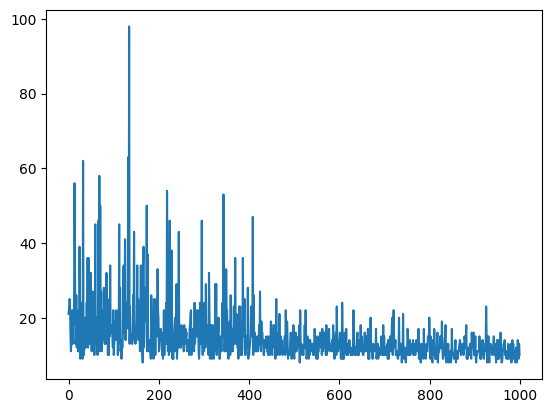

In [ ]:
import matplotlib.pyplot as plt
plt.plot(scores)

In [ ]:
env = gymnasium.make('CartPole-v1', render_mode='human')
rewards = []
for i in range(10):
    reward = 0
    u, info = env.reset()
    u = torch.tensor(u)
    while True:
        action = torch.argmax(target_q(u)).cpu().detach().item()
        v, r, terminated, truncated, info = env.step(action)
        v = torch.tensor(v)
        reward += r
        u = v
        if terminated or truncated:
            break
    rewards.append(reward)
env.close()
rewards

[50.0, 51.0, 40.0, 45.0, 42.0, 49.0, 52.0, 54.0, 54.0, 40.0]

In [ ]:
env.close()

In [ ]:
env = gymnasium.make('CartPole-v1')